## MCMC Functions

In [1]:
#from Tools import *
import numpy as np
import seaborn as sns
import pandas as pd
from BayesianInference import *
from random import Random
import random
from scipy.interpolate import interp1d
from scipy.stats import rv_continuous
from astropy.io import ascii
import emcee
import pathos.multiprocessing as multiproc
from multiprocessing import Pool
import corner
from IPython.display import display, Math
from palettable.cartocolors.qualitative import Antique_3
from matplotlib.colors import ListedColormap
import seaborn as sns
import glob 
import warnings

In [2]:
def Likelihood(ew,dEW,A,Wo):
    """
    Likelihood : Probability of having a certain value of EW given the exponential parameters A and Wo

    Args:
        ew: Equivalent widths observed
        A : Parameter exponential (should depend on our other observables, such as uvslope and muv)
        Wo : Parameter exponential (should depend on our other observables, such as uvslope and muv)
    """
    B=1/(1-np.exp(-1/Wo))
    A=1
    dEW_2 = dEW**2.
    p1 = (1. - A) * np.exp(-0.5 * ew**2./dEW_2) / np.sqrt(2.*np.pi) / dEW
    X  = (dEW_2/Wo - ew) / np.sqrt(2.) / dEW
    p2 = 0.5 *  ( A * B )/ Wo * np.exp(0.5*(dEW_2 - 2*ew*Wo)/Wo**2.)* ( scipy.special.erf(X+(1/(np.sqrt(2)*dEW))) -scipy.special.erf(X)  )
    p = p1 + p2
    return p


def LikUp(wtab,dew,A,Wo):
        like = Likelihood(wtab,dew,A,Wo)
        return integrate.trapz(like,wtab)

def LikLow(wtab,dew,A,Wo):
        like = Likelihood(wtab,dew,A,Wo)
        return integrate.trapz(like,wtab)

##
def ParameterModel(physParams,mathParams):
    """
    ParameterModel: Given the physical parameters and the mathematical parameters, it returns the parameter of the model
    
    Input:
    - physParams: Physical parameters (Muv)
    - mathParams: Mathematical parameters (Constants of the model A and Wo)
    Output:
    - Parameter: Parameter of the model A or Wo
    """
    Muv,Beta=physParams[0],physParams[1]
    cMuv,cBeta,cte= mathParams[0],mathParams[1],mathParams[2]
    Parameter   =   ((Muv+20)*cMuv) + ((Beta+2)*cBeta)   +   cte 
    return Parameter
####

def Posterior(fesc,dfesc,A,Wo,Detection_type,wtab):
    """
    """
    probLike=[]
    for i in range(0,len(Detection_type)):
        if Detection_type[i]=="LyaHa":
            p   =   Likelihood(fesc[i],dfesc[i],A,Wo)
        if Detection_type[i]=="Ha":
            p   =   LikUp(wtab[i],dfesc[i],A,Wo)
        if Detection_type[i]=="Lya":
            p   =   LikLow(wtab[i],dfesc[i],A,Wo)
        if np.isnan(p)==True:
            continue

        probLike.append(p)
        
    return np.array(probLike)


def log_prior(theta):
    # I can put priors here or in the equation in the BInf object 
    A,Wo= theta
    if (A >= 0.).all() and (A <= 1.).all() and (Wo >= 0.05).all() and (Wo <= 1).all():
        return 0.0 
    return -np.inf

def log_likelihood(theta,y,yerr,Detection_type,wtab):
    A,Wo= theta
    model = Posterior(y,yerr,A,Wo,Detection_type,wtab) # Does thus have to be exp, so it gets outside the logaritm?
    return np.sum(np.log(model))


def log_probability(theta, y, yerr,Detection_type,wtab):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    lL=log_likelihood(theta, y, yerr,Detection_type,wtab)
    #print(lL)
    if np.isnan(lL)==True:
        return -np.inf
    else:
        return lp + lL

## load Data

In [3]:

Catalog=ascii.read('../../A-Catalogs/Binospec-Candels.cat')
mask=np.isnan(Catalog["fesc"])==False
Catalog=Catalog[mask]
mask=Catalog["EWLya"]<500
Catalog=Catalog[mask]
mask=Catalog["Muv"]>-23.5
Catalog=Catalog[mask]

mask = (Catalog["fesc"] <= 1) | (np.isnan(Catalog["dfesc"]) == False)
Catalog = Catalog[mask]


#LowLims=['z5_GNW_12024', 'z6_GND_19165', 'z6_GNW_11543', 'z6_GND_36553', 'z5_GND_7766', 'z7_GND_43678', 'z5_GND_23860', 'z5_GND_10047', 'Stark11_43_3982', 'Jung18_z6_GND_5752', 'Stark11_42_13066', 'Stark11_32_16773']

#mask = ~np.isin(Catalog["id_charlotte"], LowLims)
#Catalog = Catalog[mask]


In [4]:
%load_ext autoreload
%autoreload

Muv=Catalog["Muv"]

Beta=Catalog["slope"]
BInf=BayesInf()
BInf.Muv=Muv
fesc_obs=Catalog["fesc"]
BInf.fesc_obs=np.array(fesc_obs)
BInf.dfesc=Catalog["dfesc"]
BInf.typesCat=Catalog["Type"]
Detection_type=BInf.DetectionTypeReal()
dfesc=[]
for gal in Catalog:
    if np.isnan(gal["dfesc"])==False:
        dfesc.append(gal["dfesc"])
    else:
        dfesc.append(np.nanmedian(Catalog["dfesc"]))



dfesc=np.array(dfesc)
Detection_type=BInf.DetectionTypeReal()

for i in range(0,len(fesc_obs)):
    print(fesc_obs[i],dfesc[i],Detection_type[i])
    if Detection_type[i]=="Ha":
        fesc_obs[i]=fesc_obs[i]/5

BInf.fesc_obs=fesc_obs
wtab=BInf.GenerateWtab_real()
fesc_obs[fesc_obs>0.999]=0.99


NonDetect nan Ha 0.05962889732415393
NonDetect nan Ha 0.8925647225995226
NonDetect nan Ha 0.3239502322242721
NonDetect nan Ha 0.8713813408198037
LAE nan Lya 0.17564175215277833
LAE 0.052251093629709276 LyaHa 0.12438463550476456
NonDetect nan Ha 0.7557508962467917
NonDetect nan Ha 0.8299358194829887
LAE nan Lya 0.34079717214121974
NonDetect nan Ha 0.20667614360363648
LAE 0.20074197610231578 LyaHa 0.33125605731453556
NonDetect nan Ha 0.19629929795465775
NonDetect nan Ha 0.5894621804536636
NonDetect nan Ha 0.45798213456087383
NonDetect nan Ha 0.8137519151430108
LAE 0.19670568472539177 LyaHa 0.38282987368995974
NonDetect nan Ha 0.6798828497249791
LAE nan Lya 0.19405380181216642
LAE nan Lya 0.3905575750582586
NonDetect nan Ha 0.391138778175178
NonDetect nan Ha 0.2940615903782802
LAE nan Lya 0.17661303510327936
NonDetect nan Ha 0.03982652444917853
NonDetect nan Ha 0.1867454920389712
LAE nan Lya 0.7074984682807727
NonDetect nan Ha 0.6842840579657601
NonDetect nan Ha 0.8295299497314397
NonDete

/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/D-EWModel/fescLya model with binning/BayesianInference.py:193: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.wtab=np.array(wtabs)


In [5]:
def get_percentile_mask(Muv, percentile_number):
    """
    Returns a mask of the specified percentile of the Muv array.

    Args:
        Muv: numpy array of Muv values
        percentile_number: integer specifying the percentile (1/3, 2/3, or 3/3)

    Returns:
        numpy array: mask of the specified percentile
    """
    percentiles = np.percentile(Muv, [50, 100])
    print(percentiles)
    if percentile_number == 1:
        mask = Muv <= percentiles[0]
    elif percentile_number == 2:
        mask = Muv > percentiles[0]
    elif percentile_number == "ALL":
        mask = Muv >-100
    else:
        raise ValueError("Invalid percentile number. Choose 1, 2")
    
    return mask

In [6]:
import seaborn as sns
%load_ext autoreload
%autoreload
# Set the seaborn theme and font scale
sns.set_theme(style="ticks",font_scale=2)
plt.rcParams["figure.figsize"] = (9,6.)
                                             #1 Blue, 2 Middle, 3 Red
mask_percentile=get_percentile_mask(Muv,2) #1 Bright, 2 Middle, 3 Faint
#mask_percentile=get_percentile_mask(Muv,1)# bright
#mask_percentile=get_percentile_mask(Beta,"ALL") #red
#mask_percentile = mask_percentile2

steps=2000                                  
nwalkers=15
inValuesW=[0.6,0.25]
inValues=inValuesW
pos = inValues+ [0.01,0.01] * np.random.randn(nwalkers,len(inValues) )
nwalkers, ndim = np.shape(pos)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(fesc_obs[mask_percentile],dfesc[mask_percentile],Detection_type[mask_percentile],wtab[mask_percentile])
)
sampler.run_mcmc(pos, steps, progress=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[-20.18371073 -18.5931739 ]


  0%|          | 8/2000 [00:00<00:55, 36.21it/s]<ipython-input-2-ae765bda6787>:74: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(model))
100%|██████████| 2000/2000 [00:43<00:00, 45.71it/s]


State([[0.53931483 0.22569802]
 [0.44686052 0.18316147]
 [0.88549897 0.21428693]
 [0.23954556 0.12757586]
 [0.33766161 0.14357488]
 [0.69432503 0.25996524]
 [0.46286054 0.1744487 ]
 [0.5107515  0.16823125]
 [0.20015507 0.23945584]
 [0.97820668 0.25523321]
 [0.10568593 0.1363162 ]
 [0.36342597 0.26850527]
 [0.5408583  0.29274183]
 [0.12664324 0.23877301]
 [0.63860453 0.2357468 ]], log_prob=[-33.30698883 -33.17494624 -33.22388711 -34.40922217 -33.7854882
 -33.67856404 -33.22716299 -33.28815068 -33.43811345 -33.61931718
 -34.03242251 -33.78997527 -34.12882092 -33.43094081 -33.39992641], blobs=None, random_state=('MT19937', array([2537075904, 1915429720, 2134627409,   81878452,  776340770,
       3638349803, 2312074640,  394921671, 1679037681, 2710632508,
         61262623,  930922824, 3585694399, 2803208351, 2458330948,
       1143525848,  451046771, 4128654067, 1663304738, 3218421410,
       2052971582, 3768576737,  436834953, 2247450792, 2542803492,
       2878680046, 3720334678, 105933

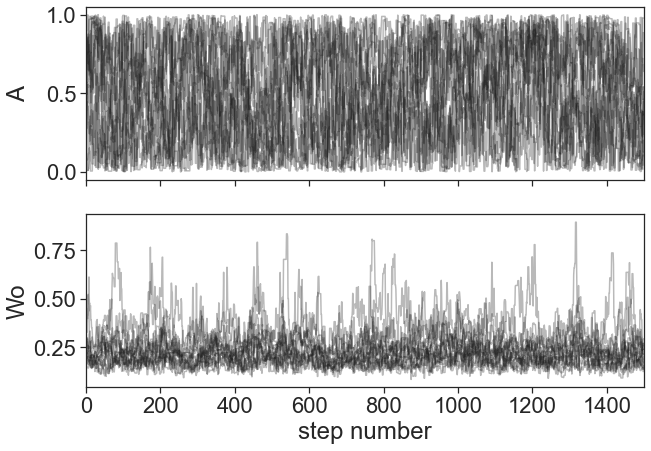

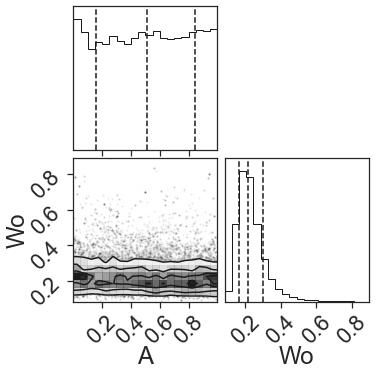

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
dis=500
labels = ["A", "Wo"]
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=dis)
logProb=sampler.get_log_prob(discard=dis)
maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
samples=np.array([s[maskWalkers] for s in samples])
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()


ndim=len(labels)
samples = sampler.get_chain(discard=dis)
samples=np.array([s[maskWalkers] for s in samples])
samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])

fig = corner.corner(
    samples, labels=labels,quantiles=[.16,.50,.84]
)
plt.show()

results=[]
r16,r84=[],[]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    results.append(mcmc[1])
    r16.append(mcmc[0])
    r84.append(mcmc[2])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
plt.hist(samples.T[0],bins=100)
print(np.percentile(samples.T[0],[68]))

In [ ]:

Catalog=ascii.read('../../A-Catalogs/Binospec-Candels.cat')

In [ ]:
Catalog[Catalog["LyaFWHM"]>800]